<a href="https://colab.research.google.com/github/komall13/Machine-Learning---Skin-type-Detection/blob/main/Machine_Leaning_Skin_type_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms #image normalization(resize,crop)
from torchvision.models import resnet50, ResNet50_Weights #img processing

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn #neural network built

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [ ]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [ ]:
train_df = create_df("/content/drive/MyDrive/AIproject/Oily-Dry-Skin-Types/train")
val_df = create_df("/content/drive/MyDrive/AIproject/Oily-Dry-Skin-Types/valid")
test_df = create_df("/content/drive/MyDrive/AIproject/Oily-Dry-Skin-Types/test")

In [ ]:
train_df = pd.concat([train_df, val_df, test_df])

In [ ]:
EPOCHS = 20
LR = 0.1 #learning Rate
STEP = 15 #lerning rate adjust for accuracy
GAMMA = 0.1 #learning Rate reduce
BATCH = 32 #total sample
OUT_CLASSES = 3
IMG_SIZE = 224

In [ ]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform #pixcel>arrymapping>transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

In [ ]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),#It switches the channel order (from HWC → CHW)
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [ ]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2) #train-Test 20/80
val, test = train_test_split(testing, random_state=42, test_size=0.5) #test 10 validation 10

In [ ]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
#Making API requests
#Downloading models
from torchvision.models import resnet50, ResNet50_Weights

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
#CUDA-Compute Unified Device Architecture
#cuda = Run on GPU
#cpu = Run on processor

#cuda operation
#Deep learning model training
#Large matrix operations
#Image processing


cpu


In [ ]:
model = deepcopy(resnet)
#Moves the model to the correct device (CPU or GPU).
model = model.to(device)
#loss function
criterion = nn.CrossEntropyLoss()
#Sets up Stochastic Gradient Descent to update the model's weights during training.
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
#Helps the model converge more smoothly by reducing the learning rate over time.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

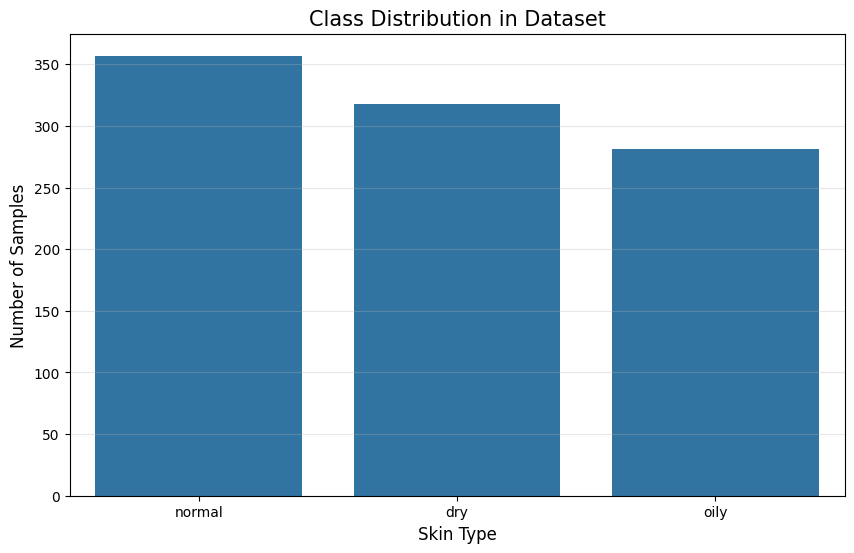

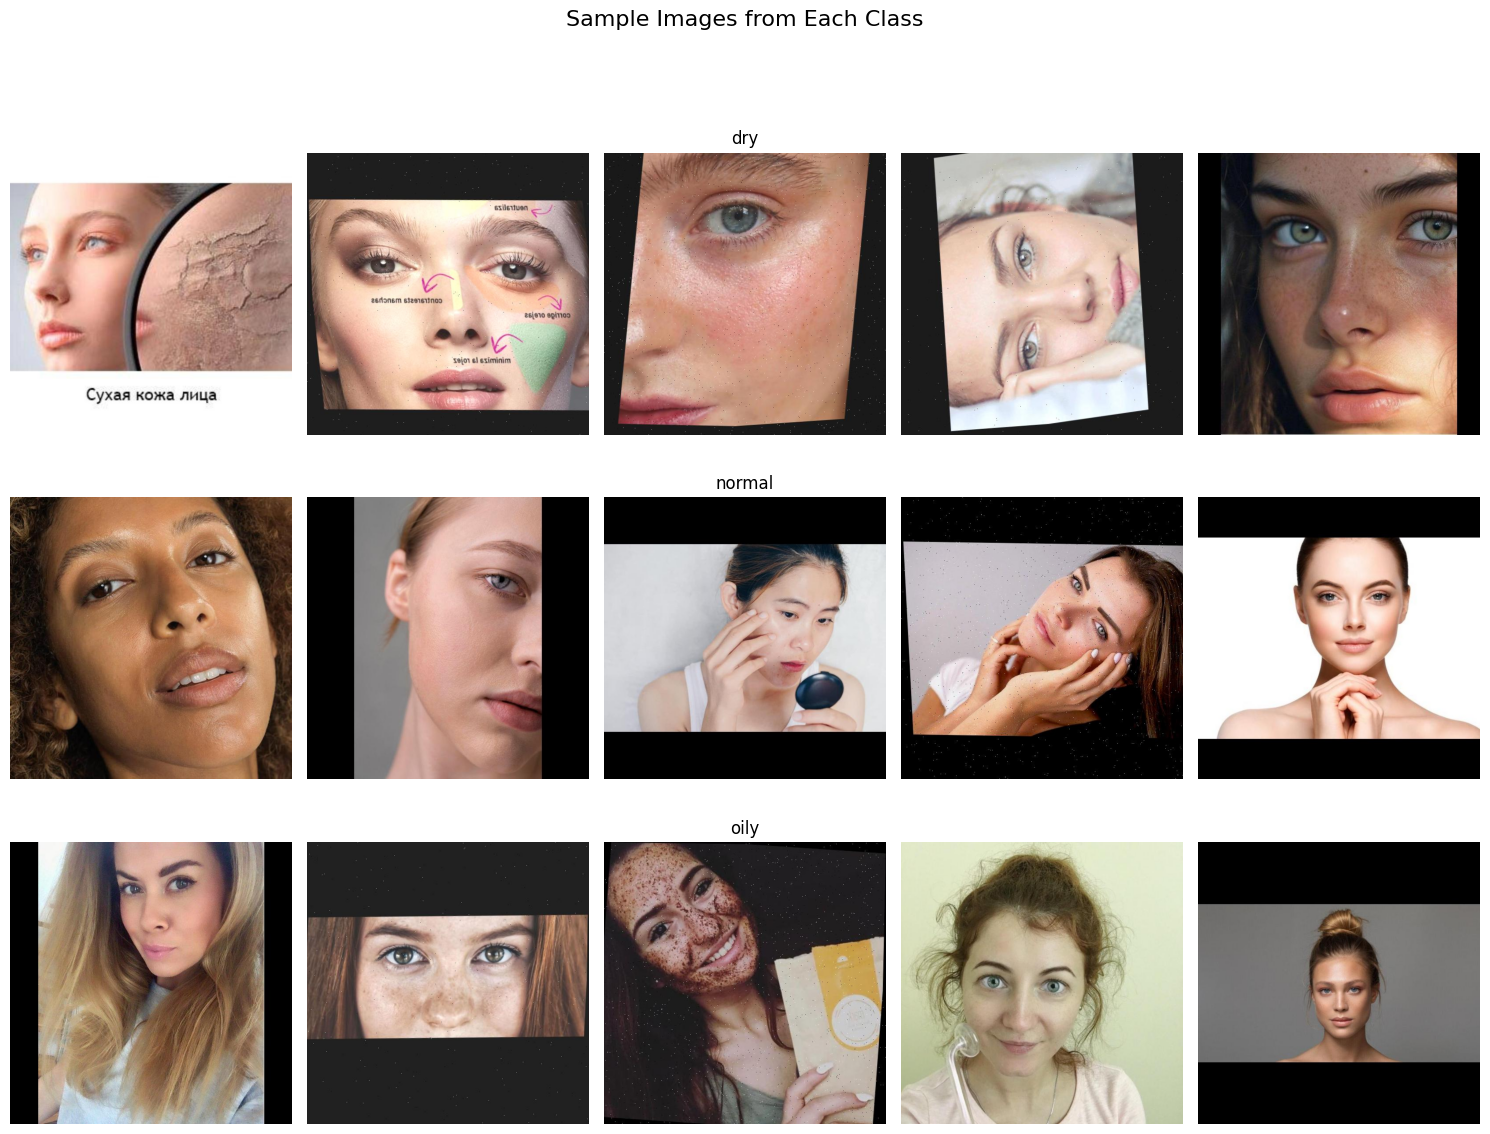

ResNet50 Architecture Summary:
Total trainable parameters: 25,557,032
Input size: 224x224x3
Output classes: 3 (dry, normal, oily)


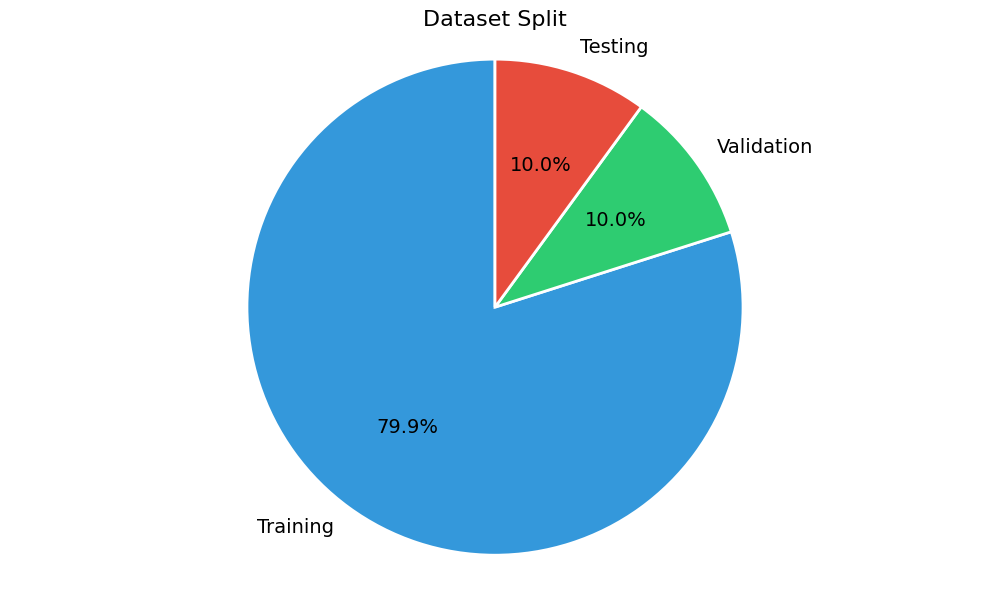

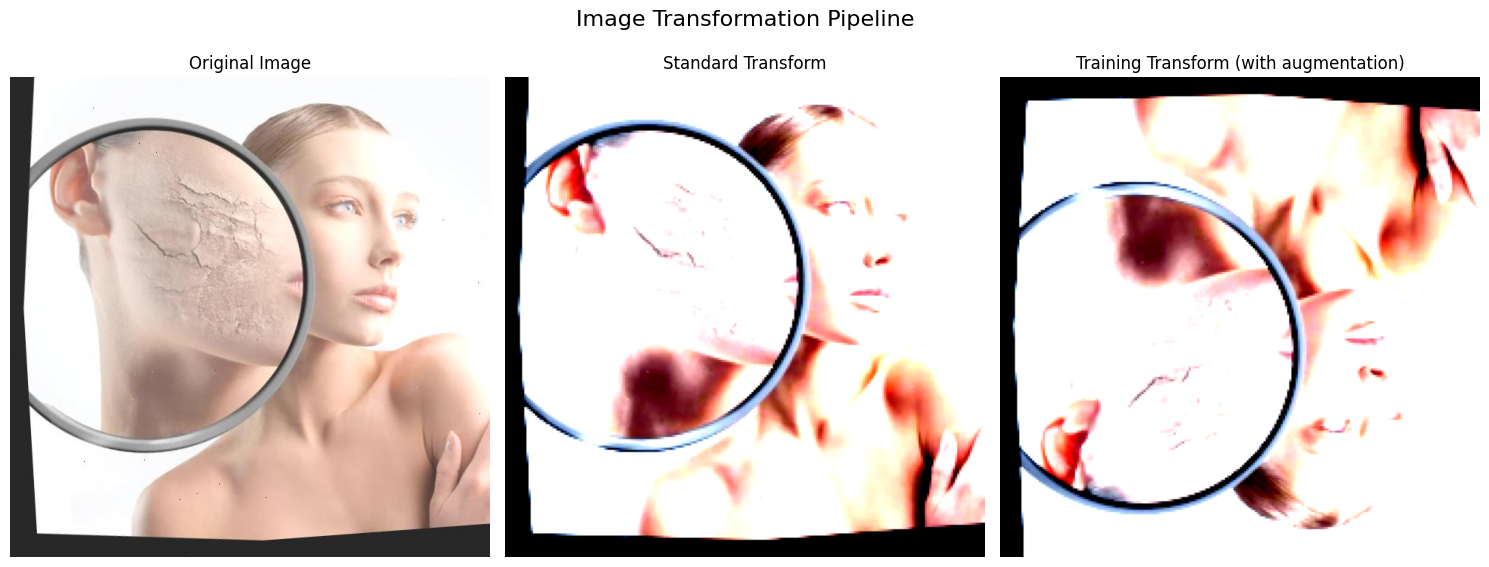

Model ready for training with ResNet50 backbone!


In [ ]:
# 1. Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts = train_df['labels'].value_counts()
sns.barplot(x=class_counts.index.map(lambda x: index_label[x]), y=class_counts.values)
plt.title("Class Distribution in Dataset", fontsize=15)
plt.xlabel("Skin Type", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2. Display sample images from each class
plt.figure(figsize=(15, 12))
for class_idx, class_name in index_label.items():
    # Get 5 random samples from this class
    class_samples = train_df[train_df['labels'] == class_idx].sample(min(5, sum(train_df['labels'] == class_idx)))

    for i, (_, row) in enumerate(class_samples.iterrows()):
        plt.subplot(3, 5, class_idx*5 + i + 1)
        img = Image.open(row['images'])
        plt.imshow(img)
        plt.axis('off')
        if i == 2:
            plt.title(f"{class_name}", fontsize=12)
plt.tight_layout()
plt.suptitle("Sample Images from Each Class", fontsize=16, y=0.98)
plt.subplots_adjust(top=0.9)
plt.show()

# 3. Model architecture visualization
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Display model summary statistics
print("ResNet50 Architecture Summary:")
print(f"Total trainable parameters: {count_parameters(model):,}")
print(f"Input size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"Output classes: {OUT_CLASSES} ({', '.join([index_label[i] for i in range(OUT_CLASSES)])})")

# 4. Data split visualization
labels = ["Training", "Validation", "Testing"]
sizes = [len(train), len(val), len(test)]
colors = ['#3498db', '#2ecc71', '#e74c3c']

plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
        textprops={'fontsize': 14}, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
plt.axis('equal')
plt.title("Dataset Split", fontsize=16)
plt.tight_layout()
plt.show()

# 5. Display transformation examples
plt.figure(figsize=(15, 6))
sample_img_path = train_df.iloc[0]['images']
original_img = np.array(Image.open(sample_img_path).convert("RGB"))

plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Original Image", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
transformed_img = transform(original_img)
plt.imshow(transformed_img.permute(1, 2, 0).numpy())
plt.title("Standard Transform", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
train_transformed_img = train_transform(original_img)
plt.imshow(train_transformed_img.permute(1, 2, 0).numpy())
plt.title("Training Transform (with augmentation)", fontsize=12)
plt.axis('off')

plt.suptitle("Image Transformation Pipeline", fontsize=16, y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

print("Model ready for training with ResNet50 backbone!")
#These are the weights and biases in the model that will be updated during training using backpropagation.

In [ ]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train() # Set model to training mode (enables dropout, batchnorm, etc.)

    diff = 0 # Sum of losses for the epoch
    total = 0 # Total number of samples seen
    acc = 0 # Count of correct predictions

    for data, target in train_dl:
        optimizer.zero_grad() # Clear previous gradients
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()# Send to GPU if available

        out = model(data) # Forward pass
        loss = criterion(out, target) # Compute loss
        diff += loss.item() # Add loss to total
        acc += (out.argmax(1) == target).sum().item() # Count correct predictions
        total += out.size(0) # Count batch size
        loss.backward() # Backpropagation
        optimizer.step() # Update weights

    train_loss += [diff/total] # Average training loss
    train_acc += [acc/total] # Average training accuracy

    model.eval() # Set model to evaluation mode (disables dropout, etc.)
    #Reset metrics again for the validation phase.
    diff = 0
    total = 0
    acc = 0

    with torch.no_grad(): # # No gradient calculation = faster, less memory
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
    #Store Epoch Validation Metrics
    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
    #Step the Learning Rate Schedu
    scheduler.step()

    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.07251971179902242 acc 0.3730366492146597 val loss 0.04844037691752116 acc 0.3854166666666667
Epochs 2 train loss 0.03203035071882278 acc 0.556282722513089 val loss 0.05695894236365954 acc 0.4166666666666667
Epochs 3 train loss 0.019420272977876414 acc 0.7539267015706806 val loss 0.03880085734029611 acc 0.5729166666666666
Epochs 4 train loss 0.015069908574613601 acc 0.8154450261780105 val loss 0.037890613079071045 acc 0.5416666666666666
Epochs 5 train loss 0.009339846144015876 acc 0.8926701570680629 val loss 0.03148207316795985 acc 0.625
Epochs 6 train loss 0.004601481258479088 acc 0.9515706806282722 val loss 0.03046311003466447 acc 0.6666666666666666
Epochs 7 train loss 0.004460793727257957 acc 0.9463350785340314 val loss 0.03180102321008841 acc 0.6770833333333334
Epochs 8 train loss 0.002232852689336732 acc 0.9777486910994765 val loss 0.0361848467340072 acc 0.65625
Epochs 9 train loss 0.0018252012221123145 acc 0.9842931937172775 val loss 0.0396494505306085 acc 0.

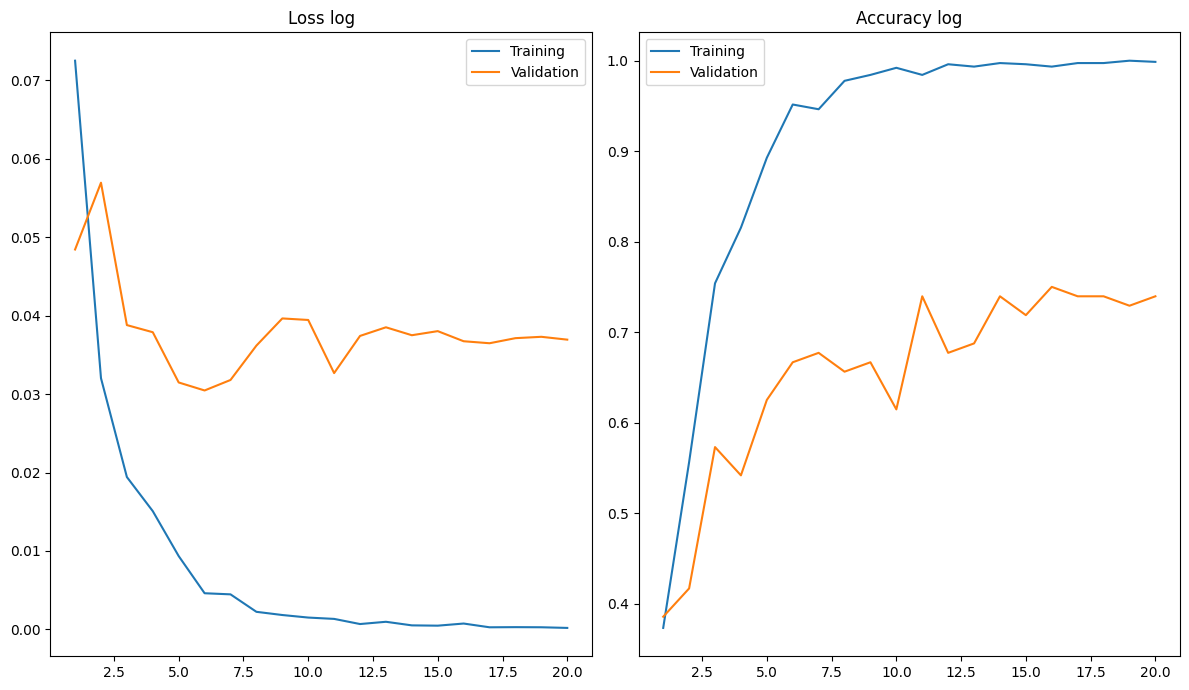

In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7)) #2plots for loss and accuracy
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout() #plt.tight_layout() adjusts the spacing to prevent overlap of elements.
plt.show()

In [ ]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    #1 = batch size
    #3 = color channels (RGB)
    #224, 224 = image dimensions (size required for ResNet-50)
    best_model.eval()#Switches the model to evaluation mode
    with torch.no_grad():
        if torch.cuda.is_available(): #If a GPU is available, the image is transferred to the GPU for f
            img = img.cuda()

        out = best_model(img) #makes a forward pass through the image to get predictions.

        return out.argmax(1).item()

In [ ]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

In [ ]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [ ]:
print(report)

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()